# Image alignment

Objetivo alinhar as imagens obtidas nas 4 faixas espectrais para obter uma imagem de 4 canais que representa o objeto e pode ser visualizada como uma imagem de falsa-cor.

![image info](./alignment-visualization.png)

a ideia inicial é usar os [descriptores](https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html).



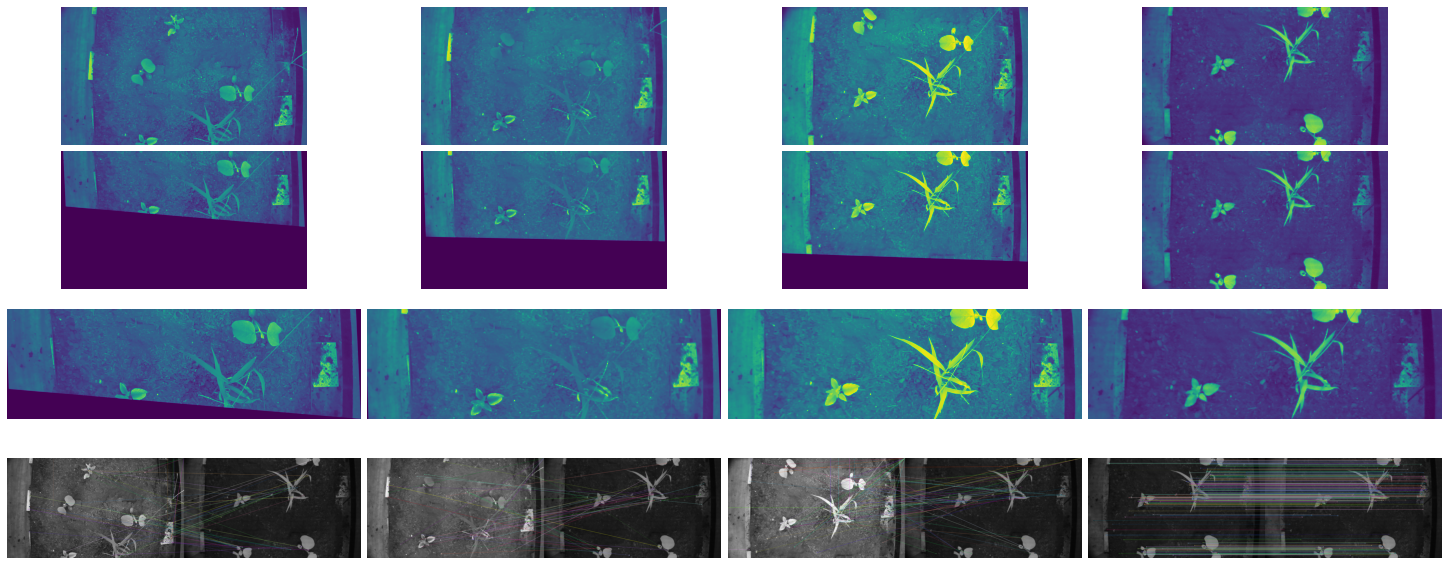

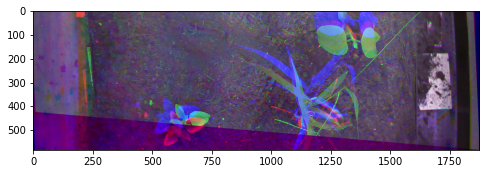

error: OpenCV(4.2.0) /home/filipe/opencv/modules/video/src/ecc.cpp:572: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'


In [2]:
import cv2
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

class Spectral_img:

    def __init__(self, paths, bands = ["G", "R", "IR", "NIR"], crop = True):

        self.min_threshold = 20
        self.offsets = [10,-10]

        self.bands = bands
        self.paths = paths
        if (len(paths) != len(bands)): 
            print ("Paths and bands with different sizes!")     
            return

        self.imgs = dict()
        self.warped_imgs = dict()
        self.croped_imgs = dict()
        self.draw_matches = []

        self.read_imgs()

        if crop:
            offset = self.imgs[self.bands[0]].shape[0]//4
            self.imgs[self.bands[0]] = self.imgs[self.bands[0]][offset:, ]
            self.imgs[self.bands[1]] = self.imgs[self.bands[1]][offset:,]
            self.imgs[self.bands[2]] = self.imgs[self.bands[2]][:-offset,]
            self.imgs[self.bands[3]] = self.imgs[self.bands[3]][:-offset]

        self.align()
        
        return
    
    def read_imgs(self):
        """ Reads the images and store in the specific band input order"""
        for index in range(len(self.bands)):
            new_img = cv2.imread(self.paths[index], 0)
            if new_img is not None:
                self.imgs[self.bands[index]] = new_img
        return

    def equalize_smooth(self, img):
        """ Histogram Normalization and gaussian blur of input image """
        img_blur = cv2.GaussianBlur(img, (3,3),0)
    #     img_blur = cv2.medianBlur(img, 5)
        img_norm = cv2.equalizeHist(img_blur)
        ret, img_norm = cv2.threshold(img_norm, self.min_threshold, 255, cv2.THRESH_TOZERO)
        return img
    
    def get_gradient(self, im):
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)

        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
        #plt.imshow(grad)
        #plt.show()
        return grad


    def warp_ECC(self, im2, im1, draw_matches = False, mode = cv2.MOTION_TRANSLATION):
        """ Align images using ECC. Modes: cv2.MOTION_TRANSLATION || cv2.MOTION_HOMOGRAPHY """
        im1_gray = self.equalize_smooth(im1)
        im2_gray = self.equalize_smooth(im2)   

        # Find size of image1
        sz = im1.shape

        # Define the motion model
        warp_mode =  mode #cv2.MOTION_TRANSLATION || cv2.MOTION_HOMOGRAPHY

        # Define 2x3 or 3x3 matrices and initialize the matrix to identity
        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            warp_matrix = np.eye(3, 3, dtype=np.float32)
        else :
            warp_matrix = np.eye(2, 3, dtype=np.float32)

        # Specify the number of iterations.
        number_of_iterations = 5000;

        # Specify the threshold of the increment
        # in the correlation coefficient between two iterations
        termination_eps = 1e-10;

        # Define termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

        # Run the ECC algorithm. The results are stored in warp_matrix.
        (cc, warp_matrix) = cv2.findTransformECC(self.get_gradient(im1_gray), self.get_gradient(im2_gray), warp_matrix, warp_mode, criteria, inputMask=None, gaussFiltSize=1)

        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            # Use warpPerspective for Homography
            im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else :
            # Use warpAffine for Translation, Euclidean and Affine
            im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
        return im2_aligned

    def warp_SIFT(self, img_original, base, draw_matches = False):
        #if (img_original.all() == base.all()): return img_original

        if (len(base.shape) > 2):
            gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
        else:
            gray = base
            
        img =  self.equalize_smooth(img_original)
        gray = self.equalize_smooth(base)   

        # Seleção dos descriptors:
        # descriptor = cv2.SIFT.create()
        descriptor = cv2.xfeatures2d.SURF_create(1000)
        descriptor.setUpright(True)
        matcher = cv2.FlannBasedMatcher()

        # get features from images
        kps_img, desc_img = descriptor.detectAndCompute(img, mask=None)
        kps_base, desc_base = descriptor.detectAndCompute(gray, mask=None)

        # find the corresponding point pairs
        if (desc_img is not None and desc_base is not None and len(desc_img) >=2 and len(desc_base) >= 2):
            rawMatch = matcher.knnMatch(desc_base, desc_img, k=2)

        matches = []
        # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
        ratio = .75
        for m in rawMatch:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        if draw_matches:
            # Apply ratio test
            good = []
            for m,n in rawMatch:
                if m.distance < 0.75*n.distance:
                    good.append([m])
            self.draw_matches.append(cv2.drawMatchesKnn(img,kps_img,gray,kps_base,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
            

        # convert keypoints to points
        pts_img, pts_base = [], []
        for id_img, id_base in matches:
            pts_img.append(kps_img[id_img].pt)
            pts_base.append(kps_base[id_base].pt)
        pts_img = np.array(pts_img, dtype=np.float32)
        pts_base = np.array(pts_base, dtype=np.float32)

        # compute homography
        if len(matches) > 4:
    #         H, status = cv2.findHomography(pts_img, pts_base, cv2.RANSAC)
            H, _ = cv2.estimateAffine2D(pts_img, pts_base)
    #         print(H)
    #         H = np.vstack((H, [0, 0, 1]))
            # print("H = ", H)
        warped = cv2.warpAffine(img_original, H, (base.shape[1], base.shape[0]))
    #     warped = cv2.warpPerspective(img_original, H, (base.shape[1], base.shape[0]))
        return warped

    def align(self, base = None, mode = "SIFT"):
        if (base == None): base =  self.bands[3]
        self.draw_matches = [] #Reset the matches drawings

        for band in self.bands:
            if mode == "SIFT":
                self.warped_imgs[band] = self.warp_SIFT(self.imgs[band], self.imgs[base], True)
            else:
                self.warped_imgs[band] = self.warp_ECC(self.imgs[band], self.imgs[base], True)
            if (band == self.bands[0]):
                    x, y, w, h  = cv2.boundingRect(cv2.findNonZero(self.warped_imgs[self.bands[0]]))
                    x, y, w, h = x+self.offsets[0], y+self.offsets[0], w+self.offsets[1], h+self.offsets[1]
            self.croped_imgs[band] = self.warped_imgs[band][y:y+h, x:x+w]

        return

    def visualize(self):

        if len(self.draw_matches) == 4: rows = 4 
        else: rows = 3

        fig, axs = plt.subplots(rows, 4, constrained_layout = True, figsize = (4*5, rows*2)) 
        for i in range(4):
            axs[0][i].imshow(s.imgs[self.bands[i]])
            axs[1][i].imshow(s.warped_imgs[self.bands[i]])
            axs[2][i].imshow(s.croped_imgs[self.bands[i]])
            if len(self.draw_matches) == 4: axs[3][i].imshow(s.draw_matches[i])
        [axi.set_axis_off() for axi in axs.ravel()]
        plt.show()
        return

    def false_color(self, channels):
        merged = cv2.merge(channels)
        plt.imshow(merged)
        plt.show()
        return 
n = "20"
paths = ["imgs/Soja_v1_2_PlantasDiversas/Soja_v1_2_PlantasDiversasG"+n+".png", "imgs/Soja_v1_2_PlantasDiversas/Soja_v1_2_PlantasDiversasR"+n+".png", "imgs/Soja_v1_2_PlantasDiversas/Soja_v1_2_PlantasDiversasNIR"+n+".png", "imgs/Soja_v1_2_PlantasDiversas/Soja_v1_2_PlantasDiversasIR"+n+".png"]
bands = ["G", "R", "IR", "NIR"]
#paths = ["imgs/Soja_v3G-01-03.png","imgs/Soja_v3R-01-03.png","imgs/Soja_v3NIR-01-03.png","imgs/Soja_v3IR-01-03.png"]
s = Spectral_img(paths, bands[::], False)

s.align(mode = "SIFT")
s.visualize()
s.false_color([s.croped_imgs["R"], s.croped_imgs["G"], s.croped_imgs["IR"]])

e = Spectral_img(paths, bands[::], False)
e.align(mode = "ECC")
e.visualize()
e.false_color([s.croped_imgs["R"], s.croped_imgs["G"], s.croped_imgs["IR"]])

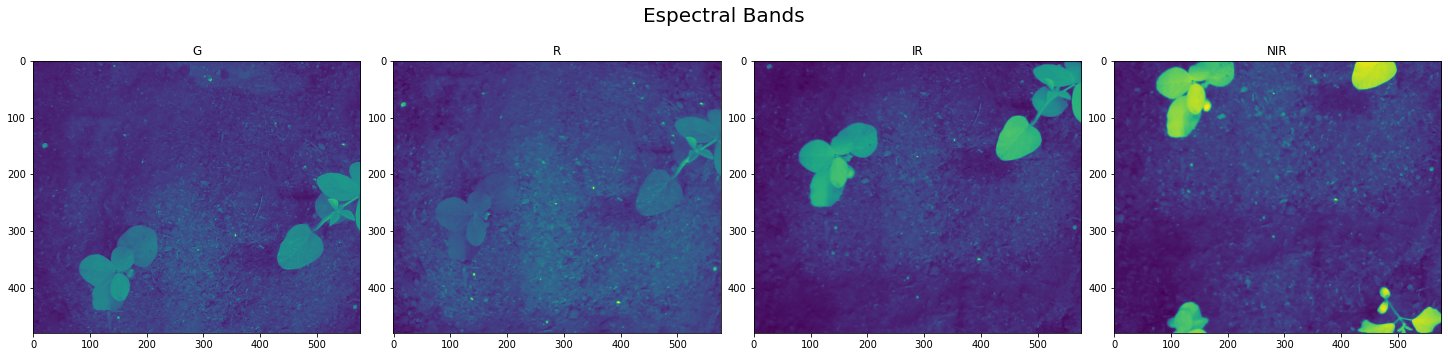

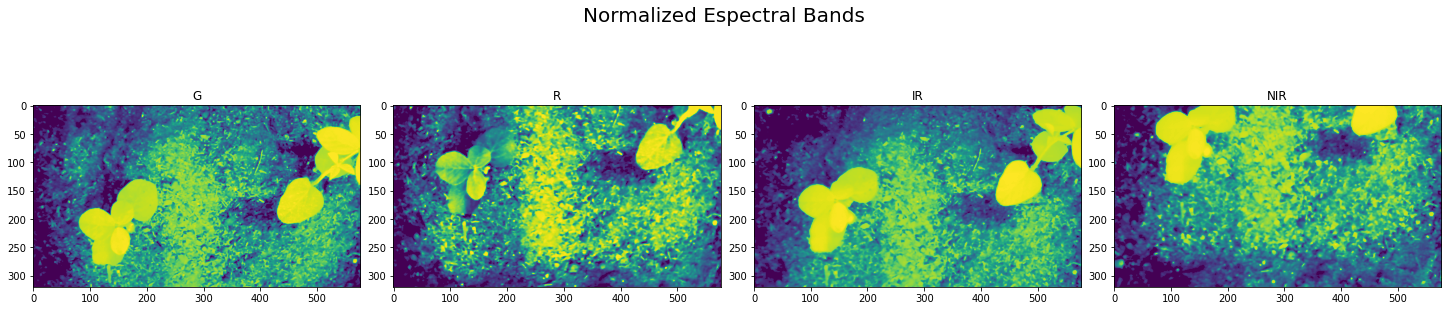

In [72]:



bands = [G,R,IR,NIR]
names = ["G","R","IR","NIR"]
# Visualização das imagens
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    ax.imshow(img[:, :])
    ax.set_title(name)
    print()
plt.show()


offset = G.shape[0]//3
G = G[offset:, ]
R = R[offset:,]
IR = IR[:-offset,]
NIR = NIR[:-offset]
bands = [G,R,IR,NIR]

# A normalização das imagens facilita a comparação entre as imagens destacando as plantas do backgroud
def equalize_smooth(img):
    """ Histogram Normalization and gaussian blur of input image """
    img_blur = cv2.GaussianBlur(img, (3,3),0)
#     img_blur = cv2.medianBlur(img, 5)
    img_norm = cv2.equalizeHist(img_blur)
    ret, img_norm = cv2.threshold(img_norm, 20, 255, cv2.THRESH_TOZERO)
    return img_norm

# Visualização das imagens normalizadas
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Normalized Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    img = equalize_smooth(img)
    ax.imshow(img)
    ax.set_title(name)

# RGB image for reference
# plt.show()
# plt.imshow(RGB)
# plt.title("RGB")
# plt.show()



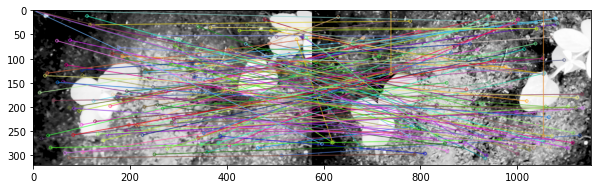

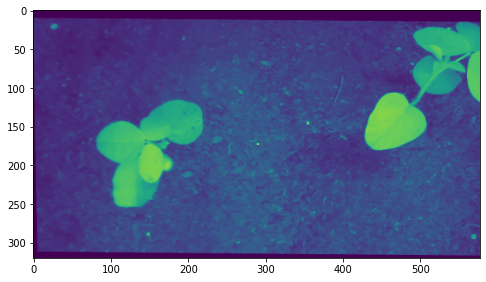

In [2]:

# Selecionar as imagens que vão ser alinhadas:
def stitch_SIFT(img_original, base, visualize = True):

    if (len(base.shape) > 2):
        gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    else:
        gray = base
        
    img =  equalize_smooth(img_original)
    gray = equalize_smooth(base)   

    # Seleção dos descriptors:
    # descriptor = cv2.SIFT.create()
    descriptor = cv2.xfeatures2d.SURF_create() #O SURF não é um algoritmo open source e só é incluido no opencv-contrib-python use com cautela.
    matcher = cv2.FlannBasedMatcher()

    # get features from images
    kps_img, desc_img = descriptor.detectAndCompute(img, mask=None)

        
    kps_base, desc_base = descriptor.detectAndCompute(gray, mask=None)

    # find the corresponding point pairs
    if (desc_img is not None and desc_base is not None and len(desc_img) >=2 and len(desc_base) >= 2):
        rawMatch = matcher.knnMatch(desc_base, desc_img, k=2)

    matches = []
    # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
    ratio = 0.75
    for m in rawMatch:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            # print("Train index: ", m[0].trainIdx, "\n Query index", m[0].queryIdx)
            # print()
            
    if visualize:
        # Apply ratio test
        good = []
        for m,n in rawMatch:
            if m.distance < 0.75*n.distance:
                good.append([m])
        img3 = cv2.drawMatchesKnn(img,kps_img,gray,kps_base,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        fig, ax = plt.subplots( figsize = (10,5))
        ax.imshow(img3)
        plt.show()
        

    # convert keypoints to points
    pts_img, pts_base = [], []
    for id_img, id_base in matches:
        pts_img.append(kps_img[id_img].pt)
        pts_base.append(kps_base[id_base].pt)
    pts_img = np.array(pts_img, dtype=np.float32)
    pts_base = np.array(pts_base, dtype=np.float32)

    # compute homography
    if len(matches) > 4:
#         H, status = cv2.findHomography(pts_img, pts_base, cv2.RANSAC)
        H, _ = cv2.estimateAffine2D(pts_img, pts_base)
#         print(H)
#         H = np.vstack((H, [0, 0, 1]))
        # print("H = ", H)
    warped = cv2.warpAffine(img_original, H, (base.shape[1], base.shape[0]))
#     warped = cv2.warpPerspective(img_original, H, (base.shape[1], base.shape[0]))
    return warped

base = G
# warped = stitch_SIFT(R, base)
warped = stitch_SIFT(IR, base)
plt.imshow(warped)


In [115]:
# visualize the result
winname = 'result'
cv2.namedWindow(winname, cv2.WINDOW_KEEPRATIO)
alpha = 5
# res = cv2.addWeighted(base, 0.5, warped, 0.5, 0)
res = None
def onChange(alpha):
    global base, warped, res, winname
    res = cv2.addWeighted(base, alpha/5, warped, 1 - alpha/5, 0)
    cv2.imshow(winname, res)
    cv2.imwrite("alignmentR"+ str(alpha) + ".png",res) # Salva as imagens mostradas pelo trackbar

onChange(alpha)
cv2.createTrackbar('alpha', winname, alpha, 5, onChange)
cv2.imshow(winname, res)

cv2.waitKey()
cv2.destroyAllWindows()

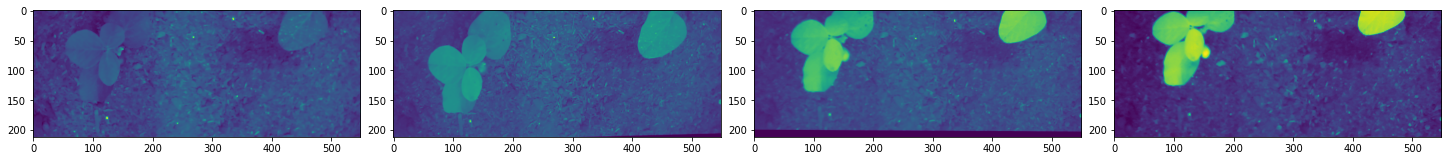

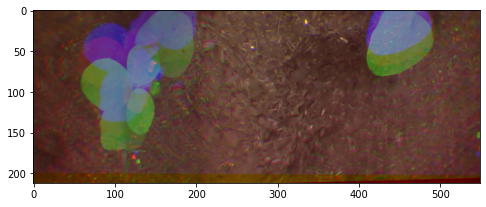

In [3]:
base = NIR
warped = stitch_SIFT(G,base, False)
x, y, w, h  = cv2.boundingRect(cv2.findNonZero(warped))
roi = warped[y:y+h, x:x+w]

# cv2.rectangle(warped, (x+10,y+10), (x+w-10, y+h-10), (125,125,125),1)
# plt.imshow(warped)
# plt.show()
# plt.imshow(roi)
# plt.show()

fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
axs[3].imshow(base[y+10:y+h-10, x+10:x+w-10])
imgs = []
i = 0
for img in [R, G,IR]:
    warped = stitch_SIFT(img,base, False)
    roi = warped[y+10:y+h-10, x+10:x+w-10]
    axs[i].imshow(roi)
    imgs.append(roi)
    i +=1
    
plt.show()
color = cv2.merge(imgs)
plt.imshow(color)
plt.show()

480 577 570 308
480 577 566 232
480 577 572 381


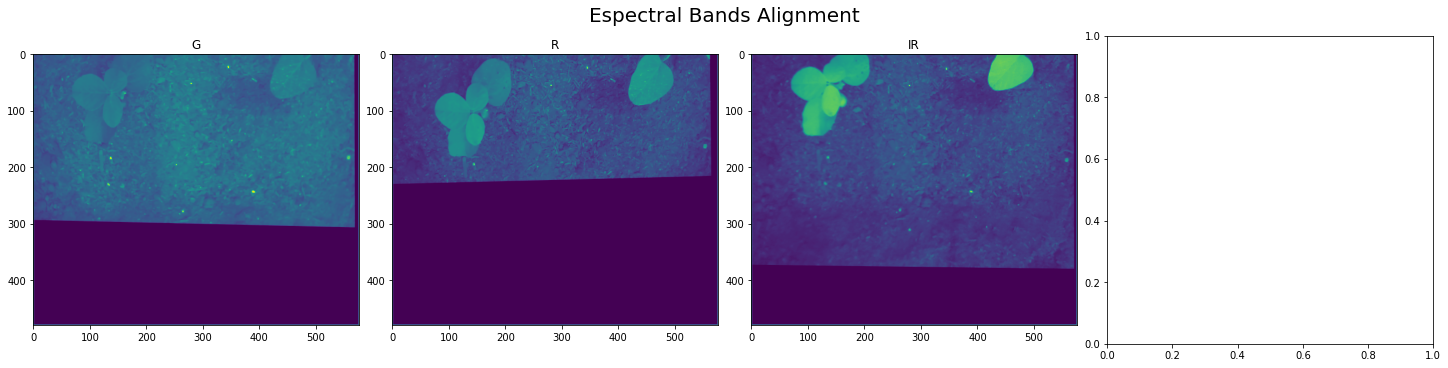

0
0
0


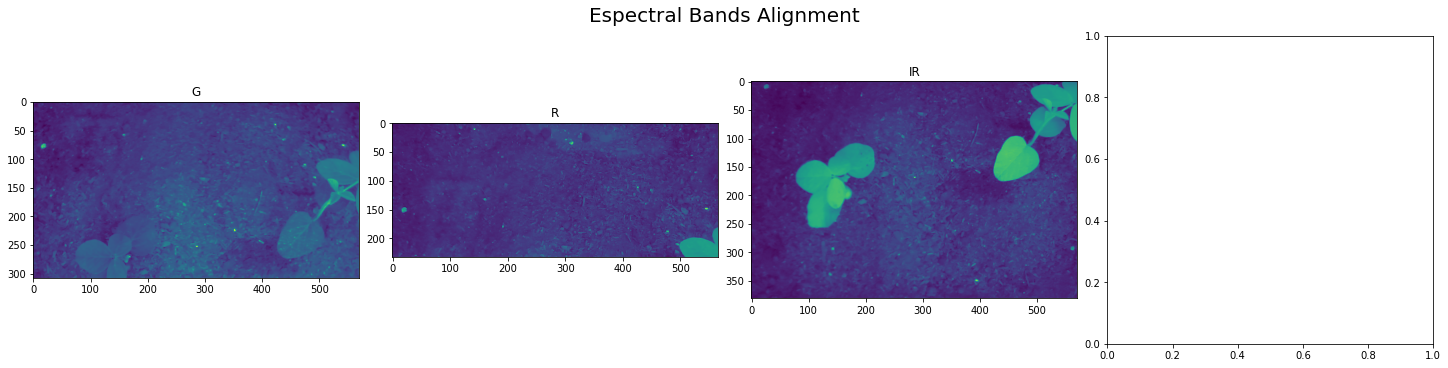

In [123]:
# Visualização da sobreposição para cada banda
base = NIR
bands_dict = dict()
spectral_img = []
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)

for (img, ax, name) in zip([R,G, IR], axs, names):
    warped = stitch_SIFT(img,base, False)
    bands_dict[name] = warped 
    ax.set_title(name)
    x, y, w, h  = cv2.boundingRect(cv2.findNonZero(warped))
    warped = cv2.rectangle(warped, (x,y), (warped.shape[1],warped.shape[0]), (100,100,100), 2)
    print(warped.shape[0], warped.shape[1], x+w, y+h)
    ax.imshow(warped)
    rect = img[:h, :w] 
    spectral_img.append(rect)
plt.show()


for img in bands_dict.values():
    rect  = cv2.boundingRect(cv2.findNonZero(img))
    print(rect[0])


fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)
spectral_dict = dict()
x, y, w, h  = cv2.boundingRect(cv2.findNonZero(bands_dict["G"]))
for (img, ax, name) in zip(spectral_img, axs, names):
    ax.imshow(img[-h:, -w:] )
    spectral_dict[name] = img[-h:, -w:]
    ax.set_title(name)
#     print(x, y, w, h)
plt.show()



In [84]:
merged = cv2.merge([spectral_dict["R"], spectral_dict["G"], spectral_dict["IR"]])
plt.imshow(merged)
plt.show()


error: OpenCV(4.5.3) /tmp/pip-req-build-afu9cjzs/opencv/modules/core/src/merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'merge'


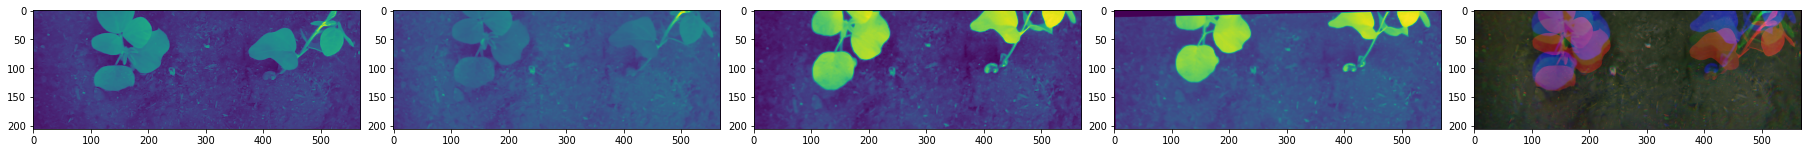

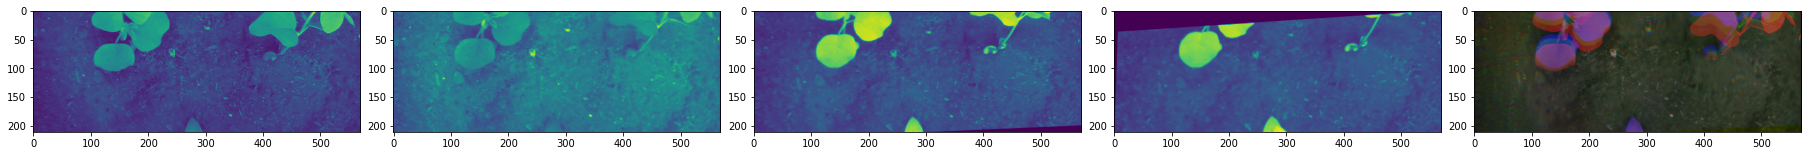

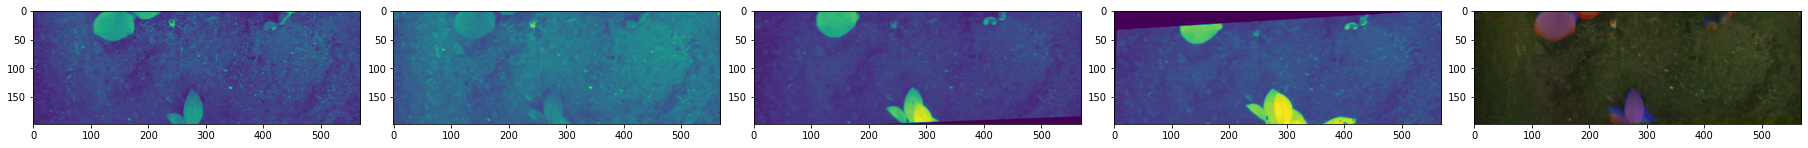

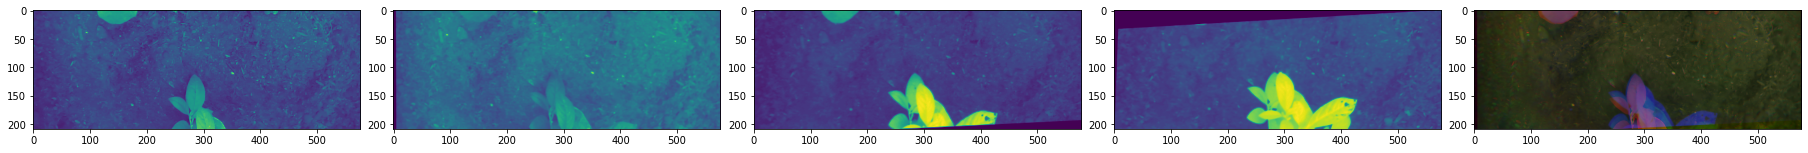

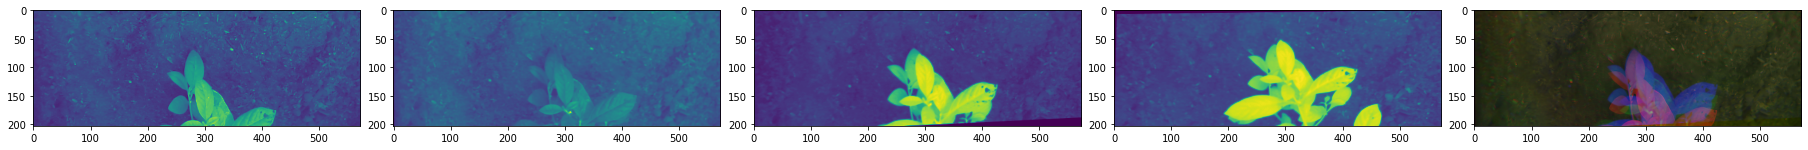

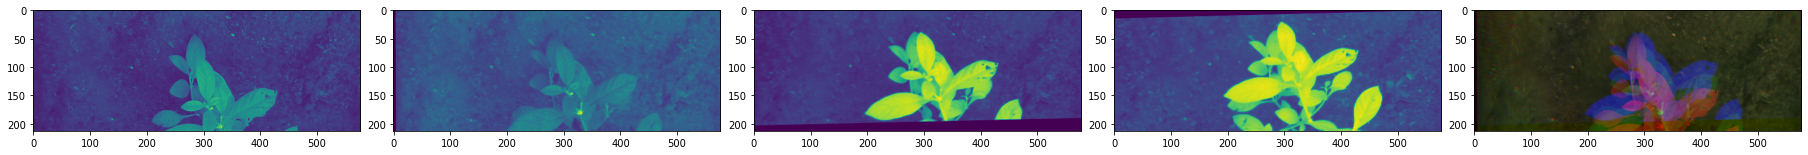

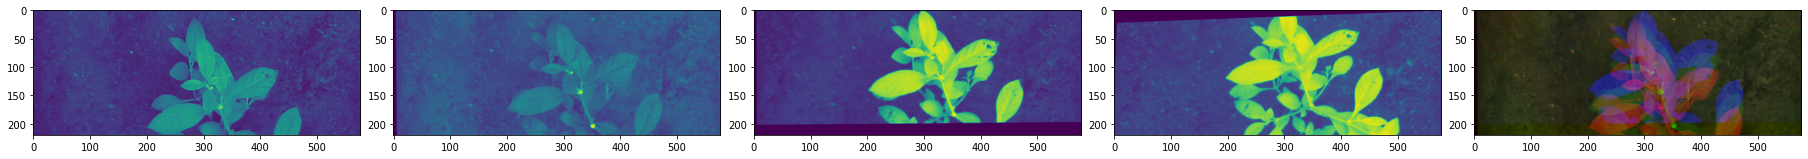

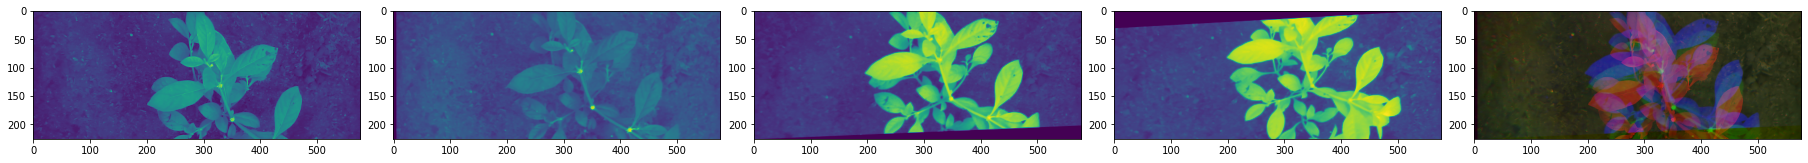

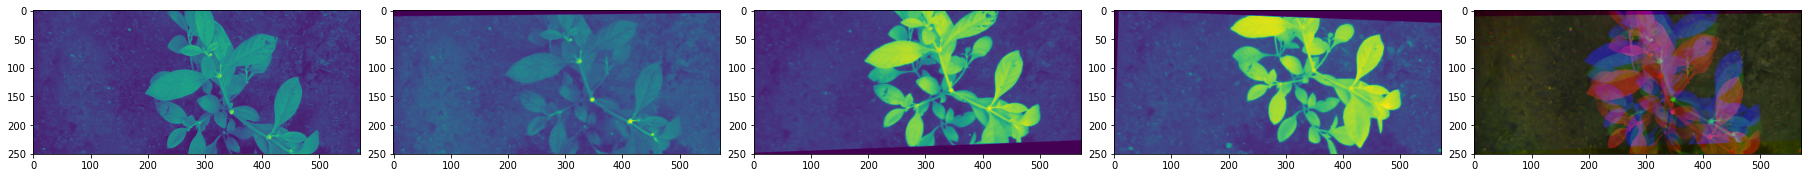

In [48]:
def align(G, R, IR, NIR):
    for (g, r, ir,nir) in zip(G, R, IR, NIR):
        
        offset = g.shape[0]//3
        g = g[offset:, ]
        r = r[offset:,]
        ir = ir[:-offset,]
        nir = nir[:-offset]
        base = g
        
        r_stitch = stitch_SIFT(r,base, False)
        ir_stitch = stitch_SIFT(ir,base, False)
        nir_stitch = stitch_SIFT(nir,base, False)
        
        x, y, w, h  = cv2.boundingRect(cv2.findNonZero(nir_stitch))
        
        g_stitch = g[y:base.shape[0], x:base.shape[1]]
        r_stitch = r_stitch[y:base.shape[0], x:base.shape[1]]
        ir_stitch = ir_stitch[y:base.shape[0], x:base.shape[1]]
        nir_stitch = nir_stitch[y:base.shape[0], x:base.shape[1]]


#         g_stitch = cv2.rectangle(g, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
#         r_stitch = cv2.rectangle(r_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
#         ir_stitch = cv2.rectangle(ir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
#         nir_stitch = cv2.rectangle(nir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        
        fig, axs = plt.subplots( 1,len(bands)+1, constrained_layout = True, figsize = ((len(bands)+1)*5, 5))
        axs[0].imshow(g_stitch)
        axs[1].imshow(r_stitch)
        axs[2].imshow(ir_stitch)
        axs[3].imshow(nir_stitch)
        
        merged = cv2.merge([g_stitch, r_stitch, ir_stitch])
        axs[4].imshow(merged)
        plt.show()
                
path = "imgs/samples-24-nov/"
bands = ["G","R", "IR", "NIR"]
Gs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"G"+"-01-01"+str(i)+".png", 0) for i in range(9)]
Rs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"R"+"-01-01"+str(i)+".png", 0) for i in range(9)]
IRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"NIR"+"-01-01"+str(i)+".png", 0) for i in range(9)]
NIRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"IR"+"-01-01"+str(i)+".png", 0) for i in range(9)] #ir and nir swapped

align(Gs, Rs, IRs, NIRs)
        

Using Enhanced Correlation Coefficient (ECC)
---

[2D Transforms](https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/)

- Use Enhanced Correlation Coefficient (ECC) algorithm to perform image alignment using the euclidean model between images 2 and 1;
- The returned transformation matrix is then used to transform image 1 with the help of cv2.warpAffine() and calculate the approximate rectangular area of the transformation in image 1;
- Repeat the same steps to transform image 3: use Enhanced Correlation Coefficient (ECC) algorithm to perform image alignment using the euclidean model between images 2 and 3;
- The returned transformation matrix is then used to transform image 3 with the help of cv2.warpAffine() and calculate the approximate rectangular area of the transformation.


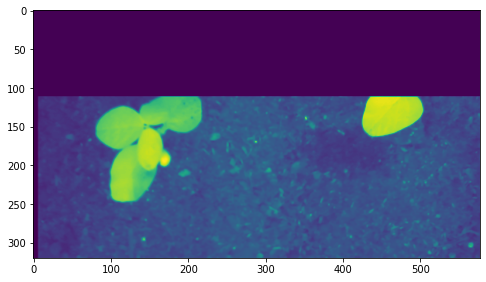

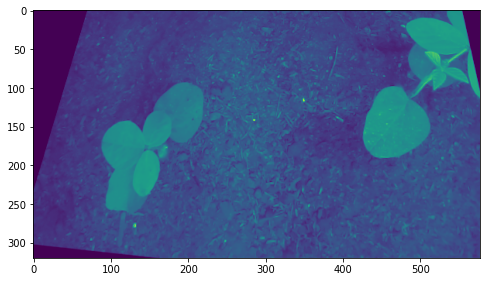

In [87]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)

    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

    return grad


def stitch_ECC(im2, im1, mode = cv2.MOTION_TRANSLATION):
    """ Align images using ECC. Modes: cv2.MOTION_TRANSLATION || cv2.MOTION_HOMOGRAPHY """

    im1_gray =  equalize_smooth(im1)
    im2_gray = equalize_smooth(im2)   

#     im1_gray = im1
#     im2_gray = im2
    
    # Convert images to grayscale
    # im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    # im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)


    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode =  mode #cv2.MOTION_TRANSLATION || cv2.MOTION_HOMOGRAPHY

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC ((im1_gray), (im2_gray),warp_matrix, warp_mode, criteria, inputMask=None, gaussFiltSize=1)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    return im2_aligned

base = IR
warped = stitch_ECC(NIR, base)
plt.imshow(warped)
plt.show()

warped = stitch_ECC(G, base, cv2.MOTION_HOMOGRAPHY)
plt.imshow(warped)
plt.show()

In [50]:
# visualize the result
winname = 'result'
cv2.namedWindow(winname, cv2.WINDOW_KEEPRATIO)
alpha = 5
# res = cv2.addWeighted(base, 0.5, warped, 0.5, 0)
res = None
def onChange(alpha):
    global base, warped, res, winname
    res = cv2.addWeighted(base, alpha/5, warped, 1 - alpha/5, 0)
    cv2.imshow(winname, res)
    cv2.imwrite("alignmentR"+ str(alpha) + ".png",res) # Salva as imagens mostradas pelo trackbar

onChange(alpha)
cv2.createTrackbar('alpha', winname, alpha, 5, onChange)
cv2.imshow(winname, res)

cv2.waitKey()
cv2.destroyAllWindows()

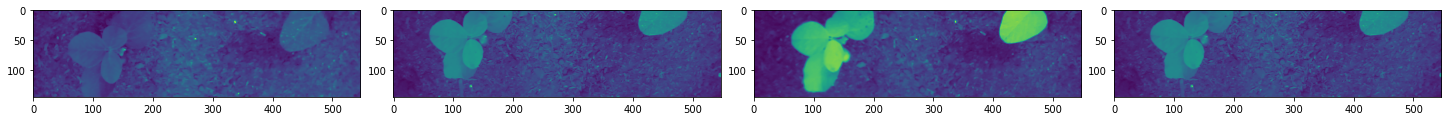

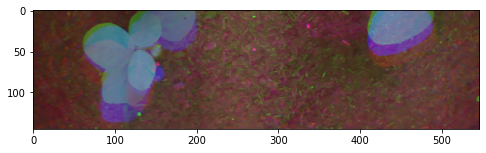

In [91]:
base = NIR
warped = stitch_ECC(G,base)
x, y, w, h  = cv2.boundingRect(cv2.findNonZero(warped))
roi = warped[y:y+h, x:x+w]

# cv2.rectangle(warped, (x+10,y+10), (x+w-10, y+h-10), (125,125,125),1)
# plt.imshow(warped)
# plt.show()
# plt.imshow(roi)
# plt.show()

fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
axs[3].imshow(warped[y+10:y+h-10, x+10:x+w-10])
imgs = []
i = 0
for img in [R, G ,IR]:
    warped = stitch_ECC(img,base)
    roi = warped[y+10:y+h-10, x+10:x+w-10]
    axs[i].imshow(roi)
    imgs.append(roi)
    i +=1
    
plt.show()
color = cv2.merge(imgs)
plt.imshow(color)
plt.show()

error: OpenCV(4.5.3) /tmp/pip-req-build-afu9cjzs/opencv/modules/video/src/ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'findTransformECC'


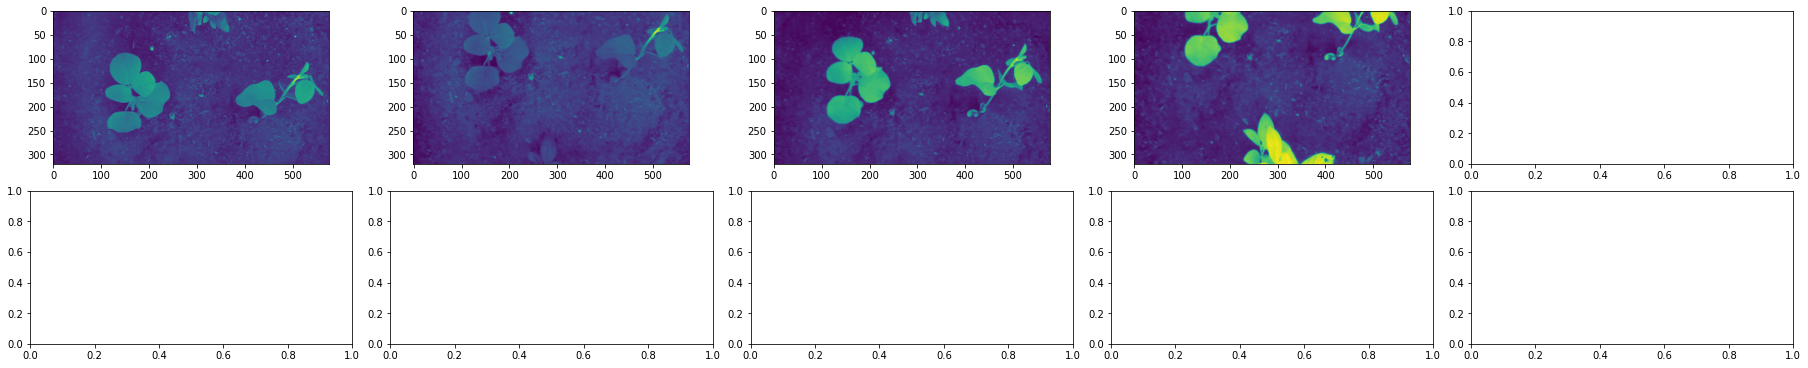

In [53]:
def align(G, R, IR, NIR):
    for (g, r, ir,nir) in zip(G, R, IR, NIR):
        
        offset = g.shape[0]//3
        g = g[offset:, ]
        r = r[offset:,]
        ir = ir[:-offset,]
        nir = nir[:-offset]
        base = g
        
        fig, axs = plt.subplots( 2,len(bands)+1, constrained_layout = True, figsize = ((len(bands)+1)*5, 5))
        axs[0][0].imshow(g)
        axs[0][1].imshow(r)
        axs[0][2].imshow(ir)
        axs[0][3].imshow(nir)
        
        r_stitch = stitch_ECC(r,base)
        ir_stitch = stitch_ECC(ir,base)
        nir_stitch = stitch_ECC(nir,base)
        
        x, y, w, h  = cv2.boundingRect(cv2.findNonZero(nir_stitch))
        
#         g_stitch = g[y:base.shape[0], x:base.shape[1]]
#         r_stitch = r_stitch[y:base.shape[0], x:base.shape[1]]
#         ir_stitch = ir_stitch[y:base.shape[0], x:base.shape[1]]
#         nir_stitch = nir_stitch[y:base.shape[0], x:base.shape[1]]


        g_stitch = cv2.rectangle(g, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        r_stitch = cv2.rectangle(r_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        ir_stitch = cv2.rectangle(ir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        nir_stitch = cv2.rectangle(nir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        
        
        axs[1][0].imshow(g_stitch)
        axs[1][1].imshow(r_stitch)
        axs[1][2].imshow(ir_stitch)
        axs[1][3].imshow(nir_stitch)
        
        merged = cv2.merge([g_stitch, r_stitch, ir_stitch])
        axs[4].imshow(merged)
        cv2.imwrite("spectral.png", merged)
        plt.show()
                
path = "imgs/samples-24-nov/"
bands = ["G","R", "IR", "NIR"]
n = 3
Gs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"G"+"-01-01"+str(i)+".png", 0) for i in range(n)]
Rs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"R"+"-01-01"+str(i)+".png", 0) for i in range(n)]
IRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"NIR"+"-01-01"+str(i)+".png", 0) for i in range(n)]
NIRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"IR"+"-01-01"+str(i)+".png", 0) for i in range(n)] #ir and nir swapped

align(Gs, Rs, IRs, NIRs)